* Name: `dissipation-theory--Study-17.ipynb`
* Author: John A. Marohn
* Date: 2024-05-31
* Continued from: ---
* Continued to: ---
* Summary: Test drive the new BLDS code.

# Preliminaries

In [25]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation import blds_perpendicular_jit
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit
import numpy as np
import matplotlib.pyplot as plt
import time

In [26]:
%matplotlib inline
import matplotlib.pylab as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [27]:
THIS = 'dissipation-theory--Study-17--'

# Explore Loring's blds signal

## Setup cantilever and sample objects

Compute the mobility in m$^2$/vs

In [49]:
mu_guess = ureg.Quantity(4e-4,'cm^2/(V s)')
mu_guess.to('m^2/(V s)')

4e-08 <Unit('meter ** 2 / second / volt')>

In [123]:
sample1_jit = SampleModel1Jit(
    cantilever = CantileverModelJit(
        f_c = 75e3, 
        V_ts = 1.0,
        R = 60e-9,  # really think 30 nm
        d = 170e-9),  # 120 + 100/2 = 170  ; "100 to 200 nm pp"
    h_s = 120e-9, 
    epsilon_s = complex(3.4, 0),
    mu = mu_guess.to('m^2/(V s)').magnitude,
    rho = 1e21,
    epsilon_d = complex(1e6, 0),
    z_r = 300e-9
)

## Fix mobility, vary charge density

Set up an array of charge densities, in units of [1/m$^3$]

In [124]:
rho = np.array([1e15, 1e17, 1e19, 1e21, 1e23, 1e25, 1e27])
rho

array([1.e+15, 1.e+17, 1.e+19, 1.e+21, 1.e+23, 1.e+25, 1.e+27])

Set up an array of frequency points at which to compute the BLDS signal.  The number of points and frequency range is close to what the Marohn team uses in experiments.

In [125]:
omega_m = ureg.Quantity(np.logspace(start=np.log10(1e2), stop=np.log10(3e6), num=25), 'Hz')
omega_m

Magnitude,[100.0 153.65500778173057 236.09861416403658 362.7773439663084 557.4255561017867 856.5122816055552 1316.0740129524927 2022.2136270154863 3107.232505953861 4774.418348819862 7336.132885411532 11272.335555957185 17320.508075688776 26613.82803153489 40893.47953287128 62834.8791584537 96548.93846056313 148352.2789047564 227950.70569547784 350257.6745748966 538188.4571241653 826953.515674511 1270655.4888609657 1952425.7902883014 3000000.000000001]
Units,hertz


In [126]:
data1 = {}
rho_original =  sample1_jit.rho
for rho_ in rho:
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')
    sample1_jit.rho = rho_
    for index, omega_ in enumerate(omega_m):
        freq[index] = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_).to('Hz')
    data1[str(rho_)] = {'x': omega_m, 'y': freq, 'rho': sample1_jit.rho, 'mu': sample1_jit.mu}
sample1_jit.rho = rho_original

In [127]:
sample1_jit.cantilever.R

6e-08

In [128]:
def plotme(data, sample_jit):

    for key in data.keys():
        
        plt.semilogx(
            data[key]['x'].to('Hz').magnitude,
            np.abs(data[key]['y'].to('Hz').magnitude),
            '-',
            label="{:0.1e}, {:0.1e}".format(data[key]['rho'],data[key]['mu']))

    lbl = '$d = $ {:0.1f} nm, $R = $ {:0.1f} nm'.format(sample_jit.cantilever.d/1e-9, sample_jit.cantilever.R/1e-9)
    plt.title(lbl, fontsize=9)
    plt.legend(title='$\\rho$ [1/m$^3$], $\\mu$ [m$^2$/Vs]', title_fontsize=9, fontsize=8, loc=(1.04, 0))
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. frequency $\omega_{\mathrm{m}}$ [rad/s]')
    plt.show()

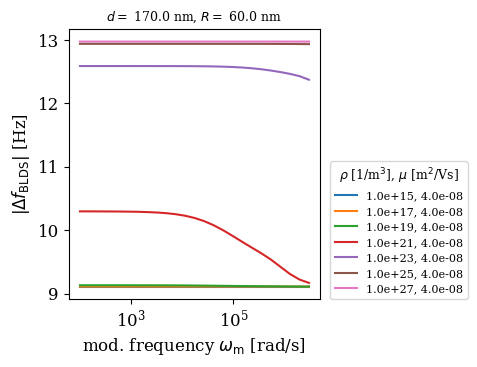

In [129]:
plotme(data1, sample1_jit)

## Fix charge density, vary mobility

Set up an array of mobilities, in units of m$^2$/Vs.

In [217]:
mu = np.array([4e-6, 4e-7, 4e-8, 4e-9, 4e-10])

In [218]:
data2 = {}
mu_original =  sample1_jit.mu
for mu_ in mu:
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')
    sample1_jit.mu = mu_
    for index, omega_ in enumerate(omega_m):
        freq[index] = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_).to('Hz')
    data2[str(mu_)] = {'x': omega_m, 'y': freq, 'rho': sample1_jit.rho, 'mu': sample1_jit.mu}
sample1_jit.mu = mu_original

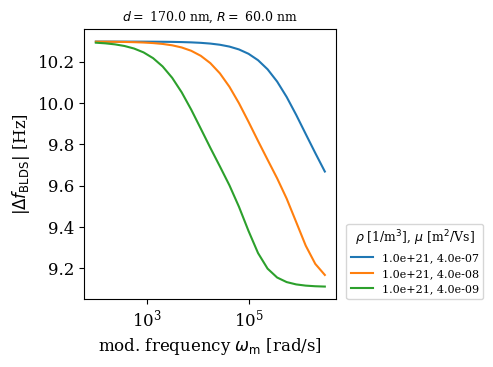

In [131]:
plotme(data2, sample1_jit)

## Change the height

In [132]:
data3 = {}
d_original = sample1_jit.cantilever.d
sample1_jit.cantilever.d = 90e-9
mu_original =  sample1_jit.mu
for mu_ in mu:
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')
    sample1_jit.mu = mu_
    for index, omega_ in enumerate(omega_m):
        freq[index] = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_).to('Hz')
    data3[str(mu_)] = {'x': omega_m, 'y': freq, 'rho': sample1_jit.rho, 'mu': sample1_jit.mu}

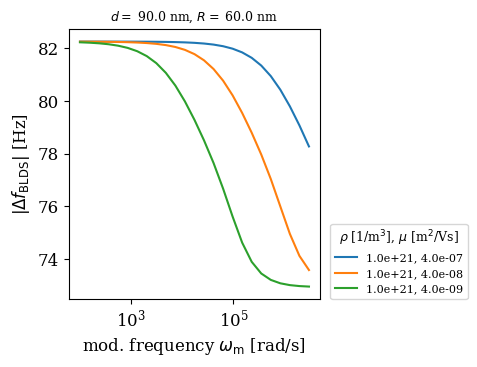

In [133]:
plotme(data3, sample1_jit)
sample1_jit.cantilever.d = d_original

# Read in data, compare to theory

In [134]:
import os
import pandas as pd

Learn about the list-unpacking trick [here](https://stackoverflow.com/questions/56390279/how-to-write-a-long-os-path-join-chain-while-complying-to-pep8).

In [135]:
filepath = ['~','Dropbox','EFM_Data_workup','pm6-y6-paper-blds-data','pm6-y6','ito','pm6-y6-ito-2']
filename = '230531-090844-BLDS-pm6-y6-3-61mA.tsv'

path = os.path.join(os.path.join(*listpath))
path

'~/Dropbox/EFM_Data_workup/pm6-y6-paper-blds-data/pm6-y6/ito/pm6-y6-ito-2/230531-090844-BLDS-pm6-y6-3-61mA.tsv'

In [136]:
df = pd.read_csv(path, sep='\t')
print(df.keys())


Index(['Modulation Frequency [Hz]', 'Mean Freq [Hz]', 'X-Channel [Hz]',
       'Y-Channel [Hz]', 'Mean Amplitude at 0 [nm]'],
      dtype='object')


In [137]:
x = df['Modulation Frequency [Hz]']
y1 = df['Mean Freq [Hz]']
y2r = df['X-Channel [Hz]']
y2i = df['Y-Channel [Hz]']
y2m = np.sqrt(y2r**2 + y2i**2)

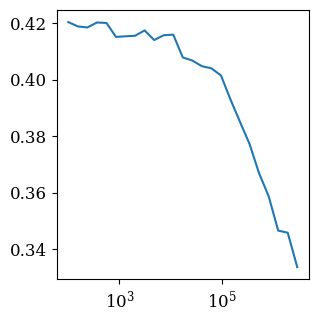

In [138]:
plt.semilogx(x, abs(y1))
plt.show()

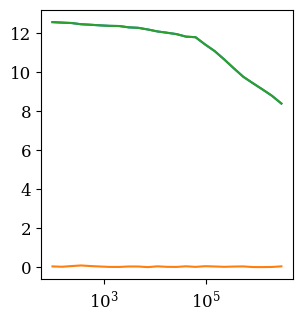

In [139]:
plt.semilogx(x, abs(y2r), label='X channel')
plt.semilogx(x, abs(y2i), label='Y channel')
plt.semilogx(x, y2m, label='magnitude')
plt.show()

In [140]:
scale = abs(y1[0]/y2m[0])
(scale, 1/scale)

(0.033444590101346115, 29.900202004860297)

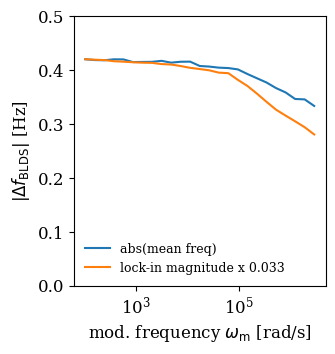

In [141]:
plt.semilogx(x, abs(y1), label='abs(mean freq)')
plt.semilogx(x, scale * abs(y2m), label='lock-in magnitude x {:0.3f}'.format(scale))
plt.legend(title_fontsize=10, fontsize=9, frameon=False)
plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
plt.xlabel('mod. frequency $\omega_{\mathrm{m}}$ [rad/s]')
plt.ylim([0,0.5])
plt.show()

Set the tip radius, tip-sample separation, and sample thickness based on data given in Cohn's draft manuscript.  Use a literature-consensus value for the mobility.  The charge density is unknown.

Play around with the tip-sample separation, the mobility, and the conductivity to get calculated blds signals that agree qualitatively with the measured signal.  I have to vary the tip-sample separation (varying the tip radius woudl also work) to get the high-frequency limit to agree with experiment.

In [206]:
sample_jit = SampleModel1Jit(
    cantilever = CantileverModelJit(
        f_c = 75e3, 
        V_ts = 1.0,
        R = 30e-9,  # really think 30 nm
        d = 235e-9),  # 120 + 157/2 = 198.5 nm; "100 to 200 nm pp", the pk-to-pk is in the SI.
    h_s = 110e-9, 
    epsilon_s = complex(3.4, 0),
    mu = mu_guess.to('m^2/(V s)').magnitude,
    rho = 1e21,
    epsilon_d = complex(1e6, 0),
    z_r = 110e-9
)

Make an array of possible charge densities.

In [207]:
def plotall(calculated, x_data, y_data, sample_jit):

    plt.semilogx(x_data, y_data, 'ko', label='data')
    
    for key in calculated.keys():
        
        plt.semilogx(
            calculated[key]['x'].to('Hz').magnitude,
            np.abs(calculated[key]['y'].to('Hz').magnitude),
            '-',
            label="{:0.1e}, {:0.1e}".format(calculated[key]['rho'],calculated[key]['mu']))

    lbl = '$d = $ {:0.1f} nm, $R = $ {:0.1f} nm'.format(sample_jit.cantilever.d/1e-9, sample_jit.cantilever.R/1e-9)
    plt.title(lbl, fontsize=9)
    plt.legend(title='$\\rho$ [1/m$^3$], $\\mu$ [m$^2$/Vs]', title_fontsize=9, fontsize=8, loc=(1.04, 0))
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. frequency $\omega_{\mathrm{m}}$ [rad/s]')
    plt.show()

In [214]:
rho = np.array([1e21, 3e21, 5e21, 1e22, 3e22, 5e22, 1e23])
mu = np.array([1e-7, 3e-7, 5e-7, 1e-8, 3e-8, 5e-8, 1e-9, 3e-9, 5e-9])

In [215]:
calculated = {}
omega_m = ureg.Quantity(x.to_numpy(), 'Hz')
rho_original =  sample_jit.rho
mu_original = sample_jit.mu
for mu_ in mu:
    sample_jit.mu = mu_
    for rho_ in rho:
        blds = ureg.Quantity(np.zeros_like(x), 'Hz')
        sample_jit.rho = rho_
        for index, omega_ in enumerate(omega_m):
            # Add in a 0.50 modulation factor for am modulation
            blds[index] = 0.50 * blds_perpendicular_jit(theta1norm_jit, sample_jit, omega_).to('Hz')
        calculated[str(rho_) + str(mu_)] = {'x': omega_m, 'y': blds, 'rho': sample_jit.rho, 'mu': sample_jit.mu}
sample_jit.mu = mu_original
sample_jit.rho = rho_original

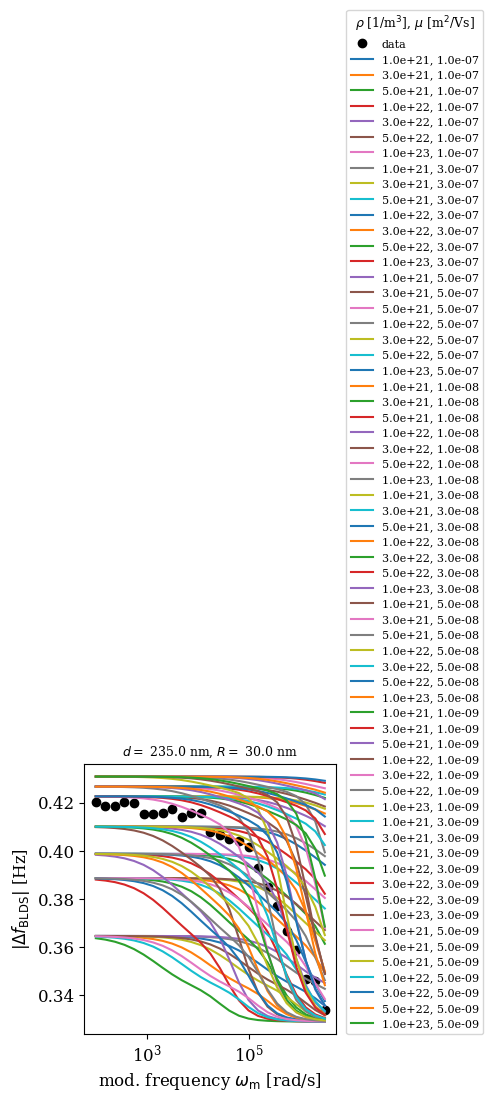

In [216]:
plotall(calculated, x, abs(y1), sample_jit)

Some of these plots looks like they might go through the data.  Think about curve fitting.

# Try least-squares fitting

In [219]:
from lmfit import Model, Parameters

In the fitting function, pick units for the separation, mobility, and density so that these parameters come out close to 1.

In [231]:
def fitfunc(x, separation, mobility, density): 

    d = separation * 1e-9
    mu = mobility * 1e-8
    rho = density * 1e21
    
    sample_jit = SampleModel1Jit(
        cantilever = CantileverModelJit(
            f_c = 75e3, 
            V_ts = 1.0,
            R = 30e-9,  # really think 30 nm
            d = d),
        h_s = 110e-9, 
        epsilon_s = complex(3.4, 0),
        mu = mu,
        rho = rho,
        epsilon_d = complex(1e6, 0),
        z_r = d
    )
    omega_m = ureg.Quantity(x, 'Hz')
    blds = ureg.Quantity(np.zeros_like(x), 'Hz')
    for index, omega_ in enumerate(omega_m):
            blds[index] = 0.50 * blds_perpendicular_jit(theta1norm_jit, sample_jit, omega_).to('Hz')
    
    return abs(blds.to('Hz').magnitude)

Let's play with the initial parameters to see if we can get close.

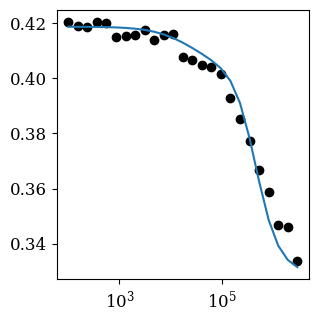

In [240]:
x_fit = x.to_numpy()
y_fit = abs(y1)
y_calc = fitfunc(x_fit, 235, 0.4, 20)

plt.semilogx(x_fit, y_fit, 'ko')
plt.semilogx(x_fit, y_calc, '-')
plt.show()

Start 10:11pm, finish before 10:12pm.  So, pretty fast.  But I started with the values already fitting pretty well.

In [242]:
gmodel = Model(fitfunc)

pars= Parameters() 
pars.add('separation', value=235, min=50, max=300)
pars.add('mobility', value=0.4, min=0.01, max=100)
pars.add('density', value=20, min=0.01, max=100)

result = gmodel.fit(y_fit, x=x_fit, params=pars)
result 

Let's look at the fit.

Plot the fit result with nice axis labels.

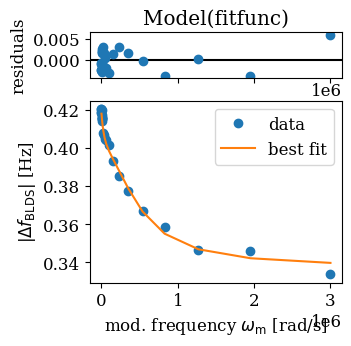

In [300]:
p = result.plot(
    xlabel='mod. frequency $\omega_{\mathrm{m}}$ [rad/s]',
    ylabel='|$\Delta f_{\mathrm{BLDS}}$| [Hz]',
    title='')

Replot with log $x$ axis.  It was a little tricky to figure out how to do this!

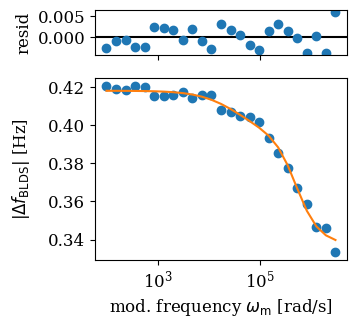

In [301]:
ax = p.get_axes()
ax[0].set_title('')
ax[0].set_xscale('log')
ax[0].set_ylabel('resid')
ax[1].set_xscale('log')
ax[1].get_legend().remove()
p.align_ylabels()
p

Success!

Now print out the best-fit parameters, remembering to multiply by the scaling parameters.

In [348]:
def print_results(result):
    
    mu = result.params['mobility'].value * 1e-8
    dmu = result.params['mobility'].stderr * 1e-8

    rho = result.params['density'].value * 1e21
    drho = result.params['density'].stderr * 1e21
    
    print(f"  d = {result.params['separation'].value:0.2f} +/- {result.params['separation'].stderr:0.2f} nm")
    print(f" mu = {mu:0.2e} +/- {dmu:0.2e} m^2/(V s)")
    print(f"rho = {rho:0.2e} +/- {drho:0.2e} 1/m^3")

In [349]:
print_results(result)

  d = 233.10 +/- 0.35 nm
 mu = 8.54e-09 +/- 7.64e-10 m^2/(V s)
rho = 8.26e+21 +/- 9.31e+20 1/m^3


In [310]:
(ureg.Quantity(result.params['separation'].value, 'nm'), 
 ureg.Quantity(result.params['mobility'].value * 1e-8, 'm^2/(V s)').to('cm^2/(V s)'),
 ureg.Quantity(result.params['density'].value * 1e21, '1/m^3'))

(233.09739098437612 <Unit('nanometer')>,
 8.53840348754729e-05 <Unit('centimeter ** 2 / second / volt')>,
 8.259570347802535e+21 <Unit('1 / meter ** 3')>)

What if we try to fit the blds sigmal instead?

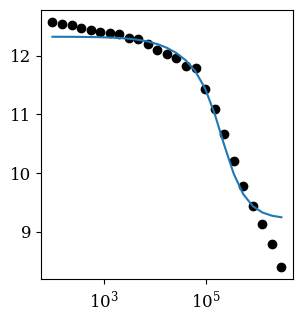

In [339]:
x_fit = x.to_numpy()
y_fit = y2m   # <=== change this
y_calc = fitfunc(x_fit, 82, 0.3, 10)  #< == change thiis

plt.semilogx(x_fit, y_fit, 'ko')
plt.semilogx(x_fit, y_calc, '-')
plt.show()

In [340]:
gmodel = Model(fitfunc)

pars= Parameters() 
pars.add('separation', value=235, min=50, max=300)
pars.add('mobility', value=0.4, min=0.01, max=100)
pars.add('density', value=20, min=0.01, max=100)

result2 = gmodel.fit(y_fit, x=x_fit, params=pars)
result2 

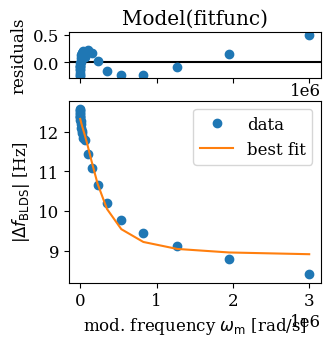

In [350]:
p2 = result2.plot(
    xlabel='mod. frequency $\omega_{\mathrm{m}}$ [rad/s]',
    ylabel='|$\Delta f_{\mathrm{BLDS}}$| [Hz]',
    title='')

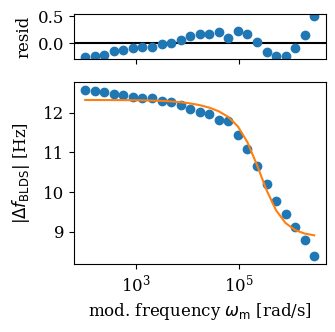

In [351]:
ax = p2.get_axes()
ax[0].set_title('')
ax[0].set_xscale('log')
ax[0].set_ylabel('resid')
ax[1].set_xscale('log')
ax[1].get_legend().remove()
p2.align_ylabels()
p2

Observations:

* `result`: Fitting to mean frequency, column 2, gives a comparatively better fit.  The best-fit tip-sample separation $d$ is somewhat larger than expected.
* `result2`: Fitting ot the lock-in blds signal gives a comparatively worse fit. The best-fit $d$ is unphysically small.

Here are the best-fit parameters for the two fits:

In [357]:
print_results(result)

  d = 233.10 +/- 0.35 nm
 mu = 8.54e-09 +/- 7.64e-10 m^2/(V s)
rho = 8.26e+21 +/- 9.31e+20 1/m^3


In [358]:
print_results(result2)

  d = 82.98 +/- 0.29 nm
 mu = 2.40e-09 +/- 3.67e-10 m^2/(V s)
rho = 1.84e+22 +/- 3.63e+21 1/m^3


We are expecting to see $d = 170 \: \mathrm{nm}$.  Instead we see $d = 233 \: \mathrm{nm}$ in `result` and $d = 83 \: \mathrm{nm}$ in `result2`.  The other parameters are also quite different.